In [1]:
import scipy.io as scio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np

Animate from the data

In [2]:
data_path = r"C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\Transolver\\PDE-Solving-StandardBenchmark\\data\\fno\\NavierStokes_V1e-5_N1200_T20\\NavierStokes_V1e-5_N1200_T20.mat"
data = scio.loadmat(data_path)
data = data['u'] #get the velocity component
print(data.shape)

s = 300 #simulation number

test_data = data[s, :, :, :20] # 64, 64, 20

(1200, 64, 64, 20)


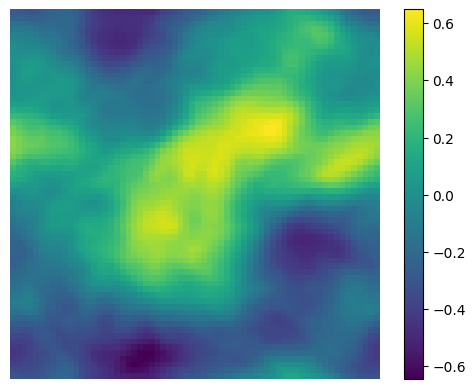

In [3]:


fig, ax = plt.subplots()
cax = ax.imshow(data[s, :, :, 0].reshape(64, 64), cmap='viridis')
ax.axis('off')

# Add colorbar
cbar = plt.colorbar(cax, ax=ax)

# Animation function
def update(frame):
    f = np.flip(data[s, :, :, frame].reshape(64, 64), 1)
    #f = data[s, :, :, frame].reshape(64, 64)
    cax.set_array(f)
    return [cax]

# Create animation
ani = animation.FuncAnimation(fig, update, frames=range(0,20), interval=200, blit=False)

ani.save("animation.gif", writer="pillow", fps=10)

#plt.imshow(data[s, :, :, 9].reshape(64, 64), cmap='coolwarm')

#plt.show()

Predict from a model

In [4]:
#load model
from phi.flow import *
import numpy as np
from phi.field import curl
from tqdm.notebook import trange
import matplotlib.pyplot as plt
from SequenSolver import SequenSolver
import torch

transolver_path = "C:\\Users\\onurb\\master\\PRJ_4ID22_TP\\codes\\Transolver\\model_weights\\encoder_ep20_head_1.pt"
model = SequenSolver(transolver_path, T=10, H=64, W=64, M=16, C=32, layers=8).cuda()


#save_name = "ns_curl_ep200_sim50"
#save_name = "ns_curl_ep400_sim50"
#save_name = "ns_curl_ep400_sim100"

#save_name = "ns_curl_unrolling_ep400_sim100"

#save_name = "ns_curl_exp_unrolling_ep400_sim100"
#save_name = "ns_curl_exp_unrolling_ep800_sim200"

#save_name = "unroll_all_ep16_sim200"
#save_name = "ns_curl_unrolling_time_ep400_sim100"

#unified transolver pos
#save_name = "ns_curl_ep200_sim50_unified"
#save_name = "ns_curl_ep400_sim100_unified"
save_name = "buff2"


model.load_state_dict(torch.load("./sequential_checkpoints/" + save_name + ".pt"), strict=False)
model.eval()

c:\Users\onurb\anaconda3\envs\cuda\Lib\site-packages\timm\models\layers\__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
c:\Users\onurb\master\PRJ_4ID22_TP\Transolver\PDE-Solving-StandardBenchmark\SequenSolver.py:70: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the 

SequenSolver(
  (model): Model(
    (preprocess): MLP(
      (linear_pre): Sequential(
        (0): Linear(in_features=65, out_features=64, bias=True)
        (1): GELU(approximate='none')
      )
      (linear_post): Linear(in_features=64, out_features=32, bias=True)
      (linears): ModuleList()
    )
    (blocks): ModuleList(
      (0-6): 7 x Transolver_Encoder_block(
        (ln_1): LayerNorm((32,), eps=1e-05, elementwise_affine=True)
        (Attn): Physics_Attention_Structured_Mesh_2D_Auto_Encoder(
          (softmax): Softmax(dim=-1)
          (dropout): Dropout(p=0.0, inplace=False)
          (in_project_x): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (in_project_fx): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (in_project_slice): Linear(in_features=32, out_features=16, bias=True)
          (to_q): Linear(in_features=32, out_features=32, bias=False)
          (to_k): Linear(in_features=32, out_features=32, bias=Fal

torch.Size([1, 4096, 2])
tensor(218.2832, device='cuda:0', grad_fn=<SumBackward0>)
tensor(917.8784, device='cuda:0', grad_fn=<SumBackward0>)
tensor(2163.5605, device='cuda:0', grad_fn=<SumBackward0>)
tensor(3764.1362, device='cuda:0', grad_fn=<SumBackward0>)
tensor(5258.0796, device='cuda:0', grad_fn=<SumBackward0>)
tensor(7009.5938, device='cuda:0', grad_fn=<SumBackward0>)
tensor(8590.2031, device='cuda:0', grad_fn=<SumBackward0>)
tensor(9323.9160, device='cuda:0', grad_fn=<SumBackward0>)
tensor(9893.4697, device='cuda:0', grad_fn=<SumBackward0>)
tensor(10730.1504, device='cuda:0', grad_fn=<SumBackward0>)


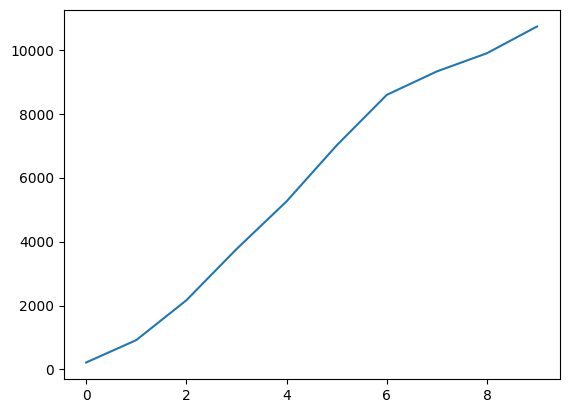

In [5]:
#define positional information
h = 64
x = np.linspace(0, 1, h)
y = np.linspace(0, 1, h)
x, y = np.meshgrid(x, y)
pos = np.c_[x.ravel(), y.ravel()]
pos = torch.tensor(pos, dtype=torch.float).unsqueeze(0).cuda()
print(pos.shape)

#predict next frames to get a simulation
test = test_data.reshape(1, -1, test_data.shape[-1]) #1, 4096, 40
test = torch.from_numpy(test)

#from frame 5 to 20, the field contains x and y field so step = 2
yy = test[..., 10:20]
fx = test[...,:10].cuda()

sim_pred = []

step = 1

losses = []

for t in range(0,10,step):
    y = yy[..., t:t + step].cuda()
    pred = model(pos, fx=fx)

    loss = torch.sum(torch.pow(pred.reshape(1, -1) - y.reshape(1, -1),2))
    losses.append(loss.detach().item())

    print(loss)

    vort = pred[0,:,0]

    vort = vort.reshape(64,64)

    # Convert to PhiFlow tensors
    vort = tensor(vort, spatial('x,y'))

    # Create a StaggeredGrid for the velocity field
    f = CenteredGrid(math.tensor(vort), extrapolation.PERIODIC)

    sim_pred.append(f)

    #update fx
    fx = torch.cat((fx[..., step:], pred), dim=-1)

c_trj_pred = phi.field.stack(sim_pred, batch('time'))

plt.plot(losses)

In [6]:
plot(c_trj_pred, animate='time', frame_time=120, overlay='args')